In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [12]:
df=pd.read_csv("Data/Preprocessed/RockBurst_transformed_data.csv")

## Using SMOTE to balance the data

In [13]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data
X = df.drop(columns=['Intensity_Level_encoded',"Intensity_Level"])
y = df['Intensity_Level_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on train set only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Intensity_Level_encoded
0    27
2    20
1    16
3     9
Name: count, dtype: int64
After SMOTE: Intensity_Level_encoded
0    27
3    27
2    27
1    27
Name: count, dtype: int64


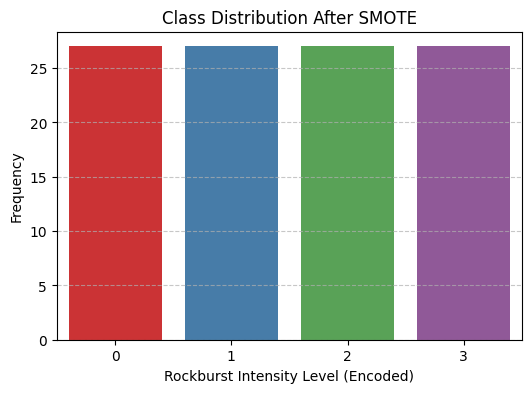

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="Set1",hue=y_train_res,legend=False)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Noise Injection To increase the samples

In [16]:
# Function to add noise
def add_noise(data, noise_factor=0.01):
    noisy_data = data.copy()
    for col in noisy_data.columns:
        if np.issubdtype(noisy_data[col].dtype, np.number):
            std_dev = noisy_data[col].std()
            noise = np.random.normal(0, std_dev * noise_factor, size=noisy_data[col].shape)
            noisy_data[col] = noisy_data[col] + noise
    return noisy_data


In [17]:
target_size = 1000
augmented_X = [X_train_res]
augmented_y = [y_train_res]

while len(pd.concat(augmented_X)) < target_size:
    X_noisy = add_noise(X_train_res, noise_factor=0.01)
    augmented_X.append(X_noisy)
    augmented_y.append(y_train_res)  # Labels same rahenge

# --- Step 4: Final Dataset ---
final_X_train = pd.concat(augmented_X).reset_index(drop=True)
final_y_train = pd.concat(augmented_y).reset_index(drop=True)

# Agar size exact 1000 chahiye
final_X_train = final_X_train.iloc[:target_size]
final_y_train = final_y_train.iloc[:target_size]

print("Final Train Size:", len(final_X_train))
print(final_y_train.value_counts())

Final Train Size: 1000
Intensity_Level_encoded
0    254
1    250
3    248
2    248
Name: count, dtype: int64


In [30]:
df=pd.concat([final_X_train,final_y_train],axis=1)

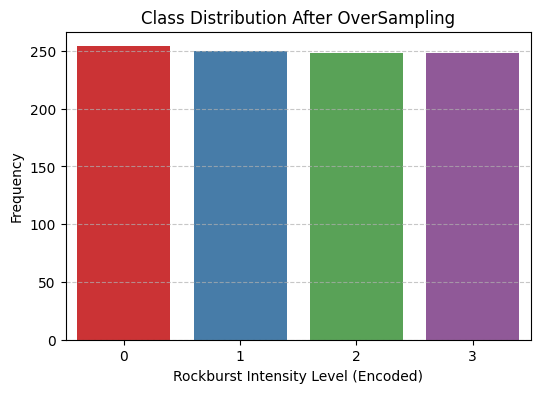

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x=final_y_train, palette="Set1",hue=final_y_train,legend=False)
plt.title("Class Distribution After OverSampling")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [31]:
df.head()

,Energy_Unit,Energy_density_Joule,Volume_m3,Event_freq_unit_per_day,Energy_Joule_per_day,Volume_m3_per_day,Duration_days,Energy_per_Volume,Energy_per_Duration,Volume_Change_Rate,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
0,1.0,1.540,4.310,1.000,1.540,4.310,1.0,0.232019,1.000000,4.310000,0.693147,2.371600,18.576100,0.693147,2.371600,18.576100,0.208654,0.693147,1.669592,0
1,1.0,4.780,2.985,1.000,4.780,2.985,1.0,0.335008,1.000000,2.985000,0.693147,22.848400,8.910225,0.693147,22.848400,8.910225,0.288938,0.693147,1.382537,0
2,29.0,5.513,4.777,5.800,4.814,4.078,5.0,6.070756,5.800000,0.815600,3.401197,30.393169,22.819729,1.916923,23.174596,16.630084,1.955967,1.916923,0.596416,3
3,5.0,2.435,3.878,0.455,1.393,2.836,11.0,1.289324,0.454545,0.257818,1.791759,5.929225,15.038884,0.375006,1.940449,8.042896,0.828257,0.374693,0.229379,0
4,14.0,4.818,4.266,1.273,3.776,3.225,11.0,3.281763,1.272727,0.293182,2.708050,23.213124,18.198756,0.821101,14.258176,10.400625,1.454365,0.820981,0.257106,2


In [35]:
df.columns[:6]

Index(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 'Volume_m3_per_day'],
      dtype='object')

In [37]:
train_df=df.drop(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 
       'Volume_m3_per_day','Energy_per_Volume','Energy_per_Duration','Volume_Change_Rate'],axis=1)

In [38]:
train_df.head()

,Duration_days,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
0,1.0,0.693147,2.371600,18.576100,0.693147,2.371600,18.576100,0.208654,0.693147,1.669592,0
1,1.0,0.693147,22.848400,8.910225,0.693147,22.848400,8.910225,0.288938,0.693147,1.382537,0
2,5.0,3.401197,30.393169,22.819729,1.916923,23.174596,16.630084,1.955967,1.916923,0.596416,3
3,11.0,1.791759,5.929225,15.038884,0.375006,1.940449,8.042896,0.828257,0.374693,0.229379,0
4,11.0,2.708050,23.213124,18.198756,0.821101,14.258176,10.400625,1.454365,0.820981,0.257106,2


In [41]:
train_df.describe()

,Duration_days,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.323357,2.458273,24.731075,18.813148,0.955608,16.851249,12.080337,1.310923,0.955767,0.438983,1.490000
std,4.217443,0.912157,10.910468,4.985417,0.444812,8.197997,3.443847,0.629586,0.444772,0.270411,1.120337
min,0.915109,0.680789,0.335347,6.205092,0.096750,-0.096342,2.708947,0.202395,0.098657,0.081243,0.000000
25%,5.037967,1.803681,19.330067,15.054265,0.689804,11.980146,9.649623,0.832917,0.689270,0.286589,0.000000
50%,8.010918,2.476407,23.588674,19.145390,0.912552,16.137154,12.879375,1.286356,0.910178,0.361881,1.000000
75%,10.037260,3.134635,33.754869,22.810024,1.207263,23.480035,14.548425,1.717428,1.210050,0.496877,2.000000
max,23.068455,4.269799,50.460383,26.775322,2.090791,34.830860,18.620656,2.691485,2.087216,1.675206,3.000000


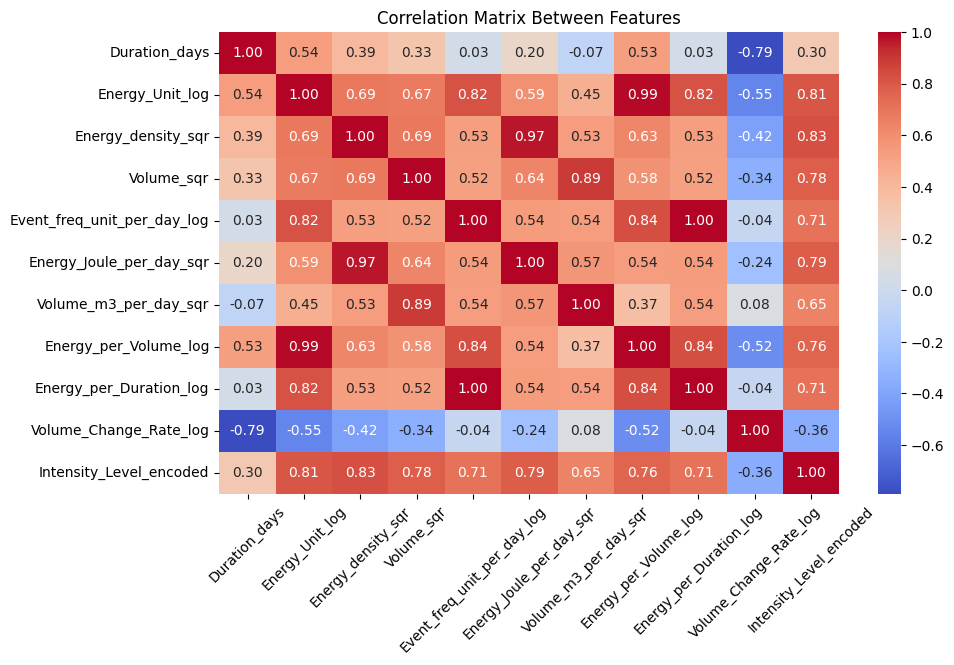

In [40]:
columns=train_df.columns
plt.figure(figsize=(10,6))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Features")
plt.xticks(rotation=45)
plt.show()


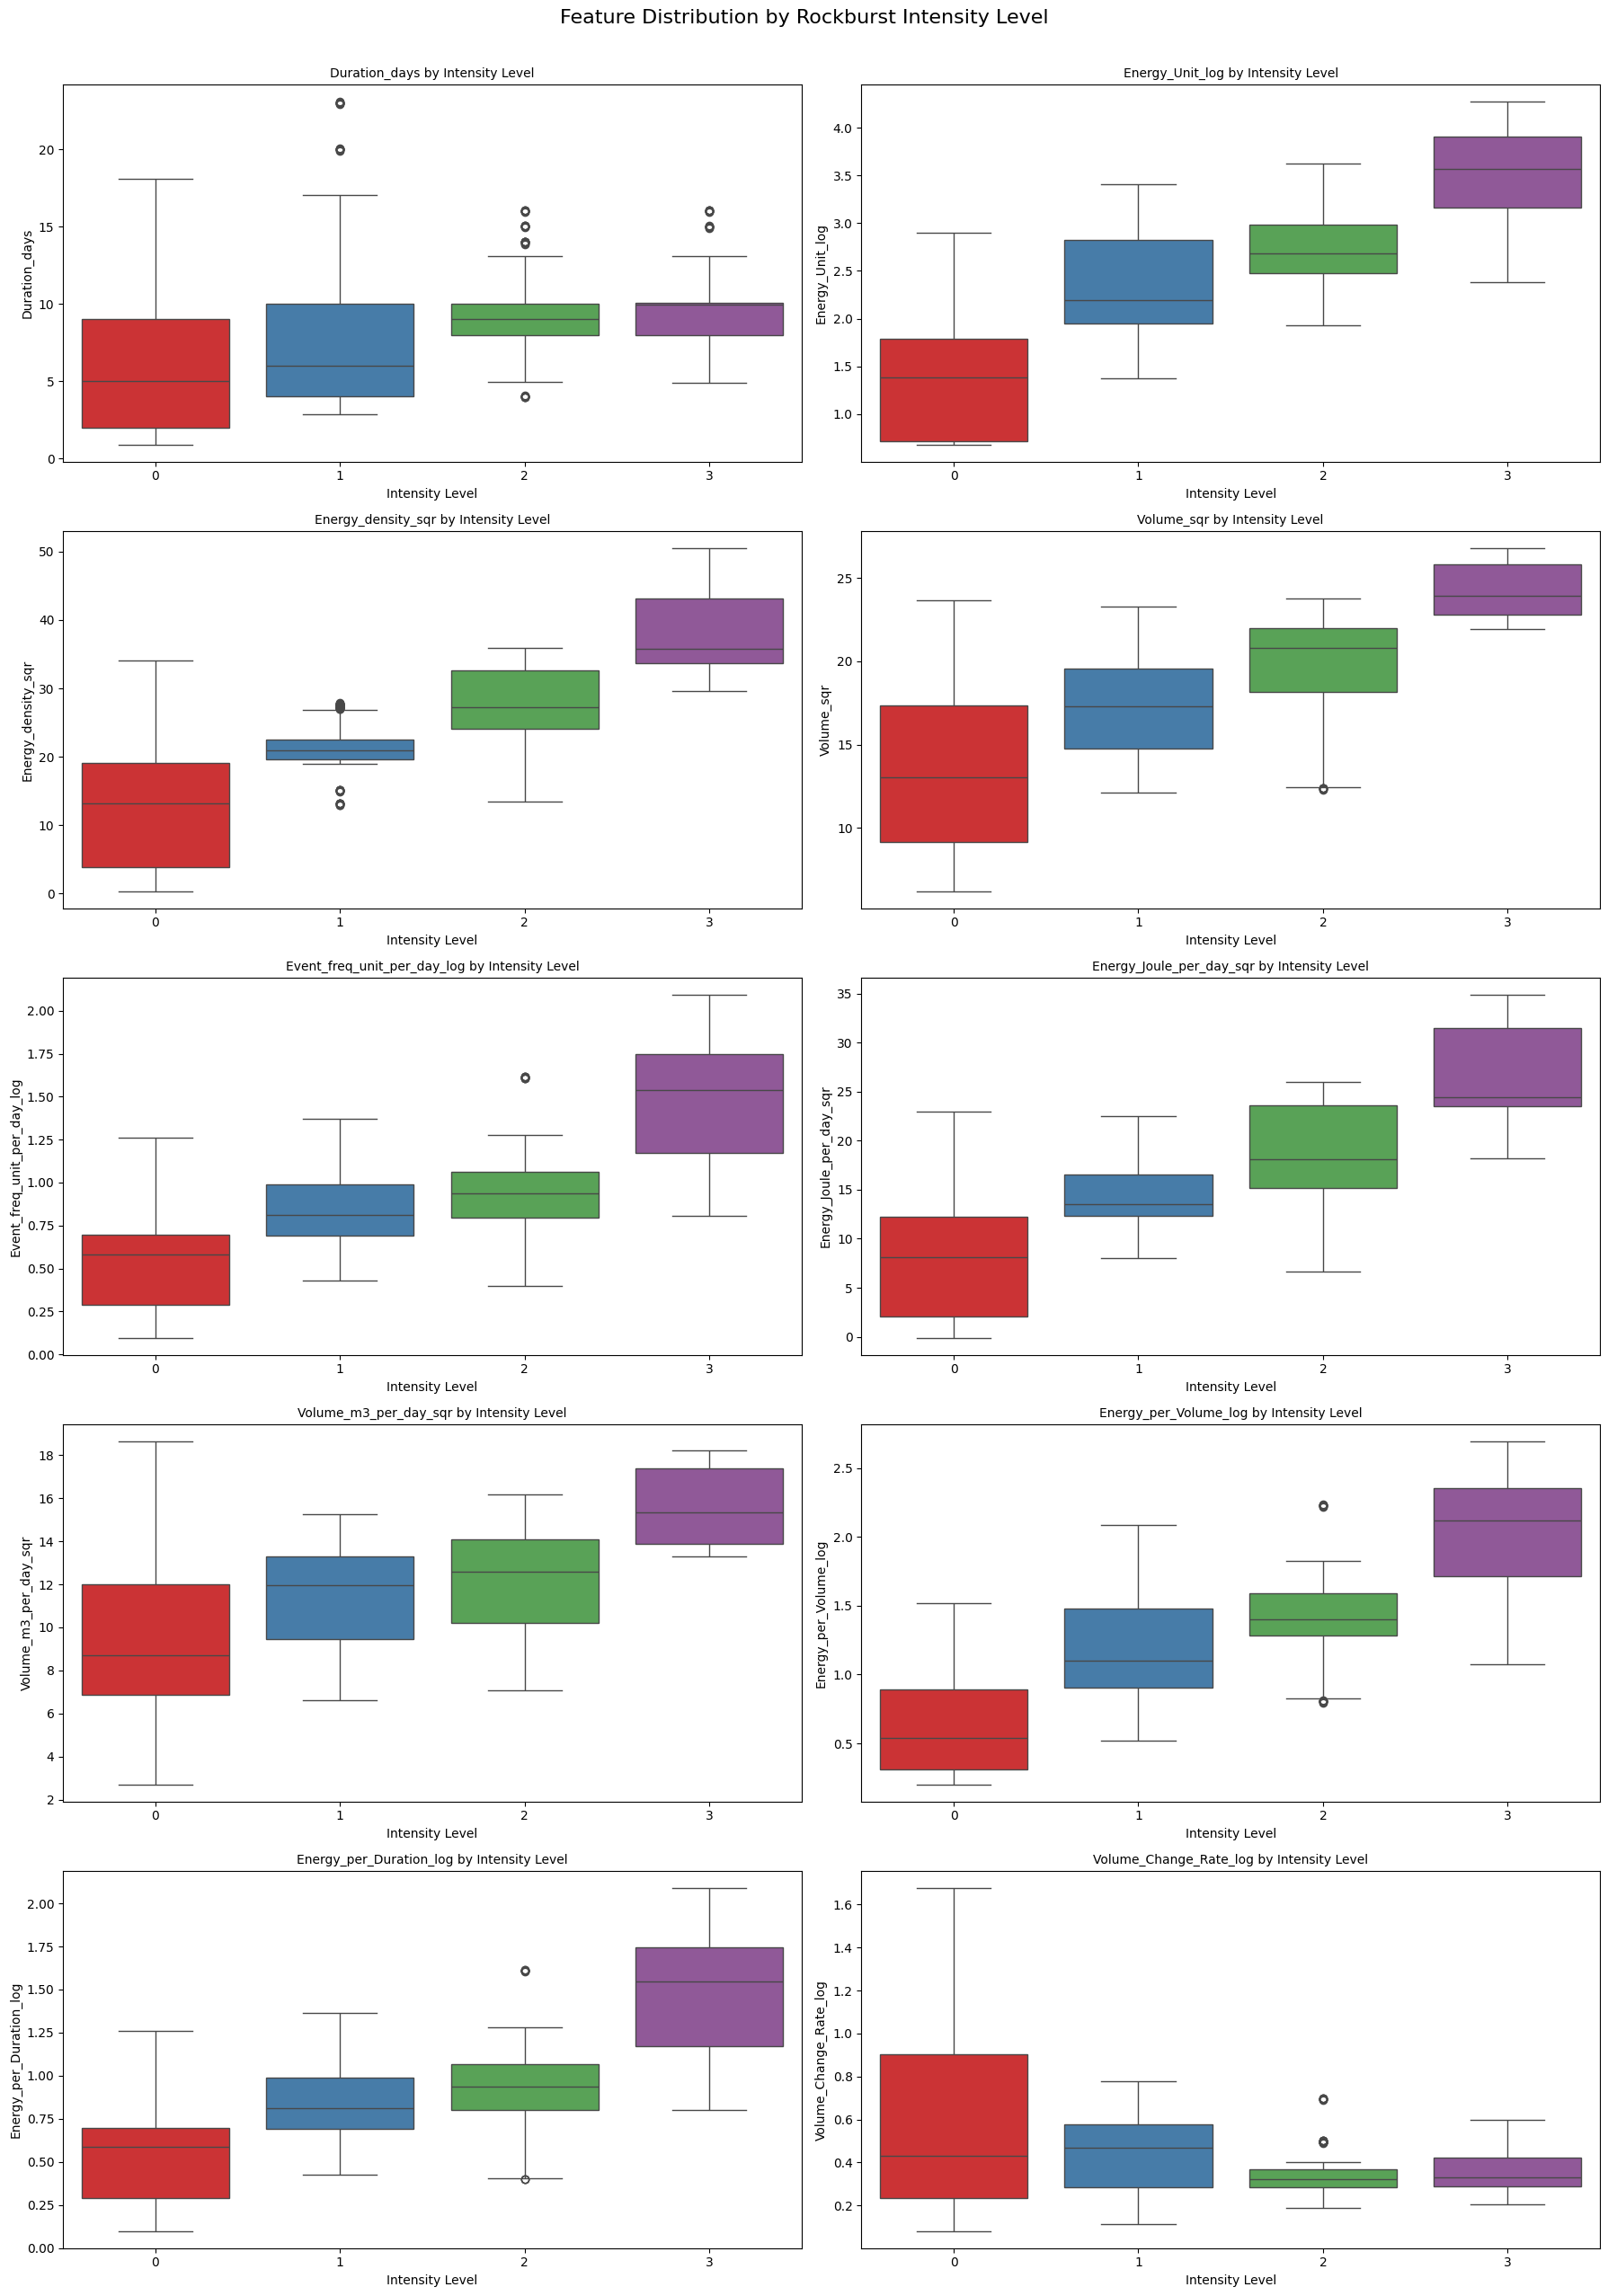

In [52]:
features = [col for col in train_df.columns if col not in ['Intensity_Level_encoded']]
n_features = len(features)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Intensity_Level_encoded', y=feature, data=train_df, palette='Set1', ax=axes[i],hue="Intensity_Level_encoded",legend=False)
    axes[i].set_title(f"{feature} by Intensity Level", fontsize=10)
    axes[i].set_xlabel("Intensity Level")
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Feature Distribution by Rockburst Intensity Level", fontsize=16, y=1.02)
plt.show()

In [71]:
train_df.to_csv("Data/Preprocessed/RockBurst_in_Tunnel_V3")

# TRAINING THE ML MODELS

In [68]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc

    print(f"\n{name} Performance:")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


c:\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:
Accuracy: 0.5789473684210527
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.29      0.40      0.33         5
           2       0.50      0.40      0.44         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macro avg       0.66      0.54      0.58        19
weighted avg       0.63      0.58      0.59        19

Confusion Matrix:
 [[6 1 0 0]
 [1 2 2 0]
 [0 3 2 0]
 [0 1 0 1]]

Random Forest Performance:
Accuracy: 0.5789473684210527
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.71      0.62         7
           1       0.50      0.20      0.29         5
           2       0.57      0.80      0.67         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macr

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7324\767161335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


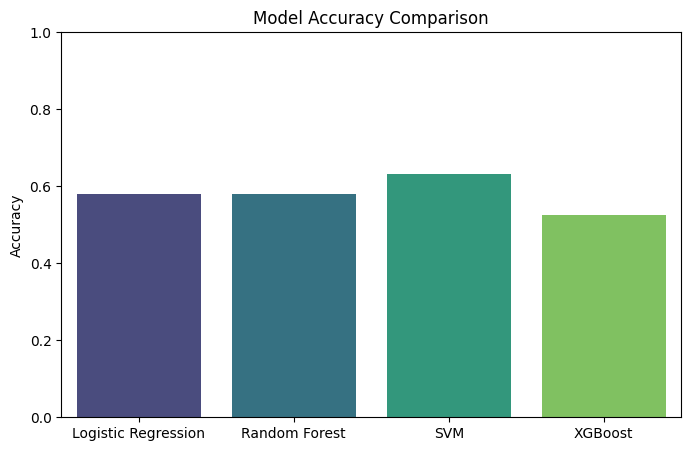

In [69]:

plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()